In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import pylab as mplot
import yaml
import h5py
import healpy as hp
import healsparse as hs

%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/chihway/.conda/envs/shear_decade/lib/python3.9/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [3]:
with h5py.File('/project2/chihway/data/decade/metacal_test_20230427_v3.hdf', 'r') as h5r:

    size = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    ra = h5r['ra'][:]
    dec = h5r['dec'][:]
    gal_e = h5r['mcal_g_noshear'][:]
    

In [4]:
mask = (size>0.5)*(s2n>10)

In [5]:
len(ra), len(s2n)

(111596425, 111596425)

In [6]:
ra_mask = ra[mask]
dec_mask = dec[mask]
size_mask = size[mask]
s2n_mask = s2n[mask]
gal_e_mask = gal_e[mask]

In [7]:
nside = 1024
map_counts = np.zeros(hp.nside2npix(nside))
map_gal_e1 = np.zeros(hp.nside2npix(nside))
map_gal_e2 = np.zeros(hp.nside2npix(nside))

phi = ra_mask/180*np.pi
theta = (90.-dec_mask)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [8]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1
    map_gal_e1[pix[i]] += gal_e_mask[i,0]
    map_gal_e2[pix[i]] += gal_e_mask[i,1]


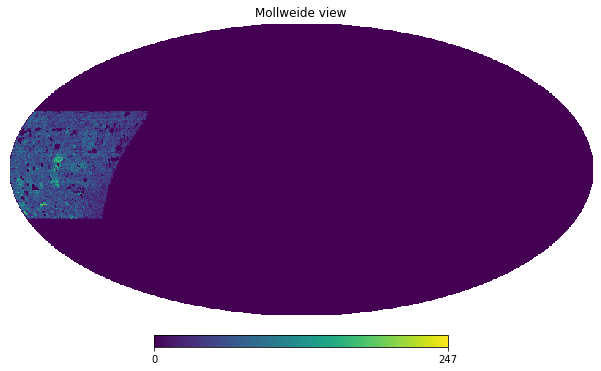

In [10]:
hp.mollview(map_counts)

/tmp/jobs/27529071/ipykernel_4461/2941008754.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.mollview(map_gal_e1/map_counts)


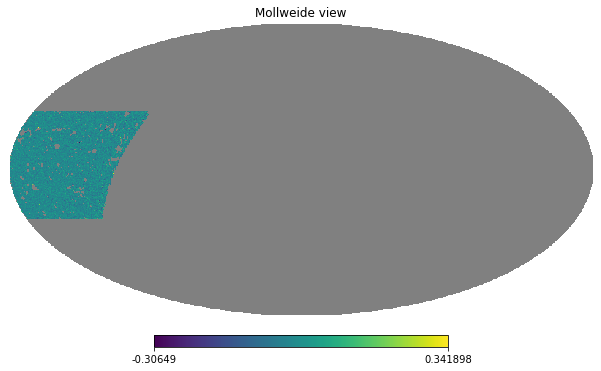

In [11]:
hp.mollview(map_gal_e1/map_counts)

/tmp/jobs/27529071/ipykernel_4461/3263655094.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.mollview(map_gal_e2/map_counts)


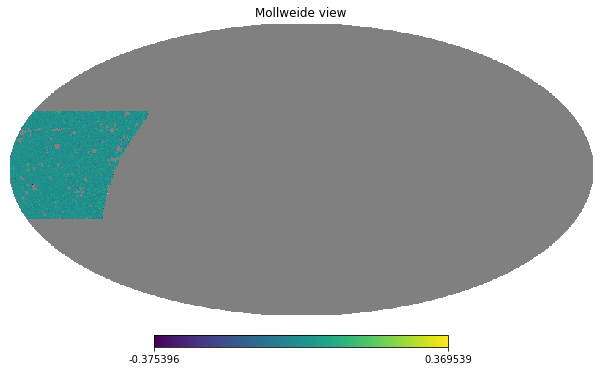

In [13]:
hp.mollview(map_gal_e2/map_counts)

In [14]:
map_shear1 = map_gal_e1.copy()
map_shear1[map_counts>0] /= map_counts[map_counts>0]
map_shear2 = map_gal_e2.copy()
map_shear2[map_counts>0] /= map_counts[map_counts>0]

In [16]:
# Define parameters
L = 2*nside 
lmax = L-1 

# Do EB separation using Healpy, even though there will be leakage near mask
KQU_masked_maps = [map_shear1*0.0+1.0, map_shear1, map_shear2]
almsnosm = hp.map2alm(KQU_masked_maps, lmax=lmax, pol=True) # Spin transform!
[kappatrue_lm, E_lm, B_lm] = hp.smoothalm(almsnosm) # extra smoothing of the mask to deal with edges

# Scalar transform to get E-B maps (at smaller resolution than input)
kappatrue_map = hp.alm2map(kappatrue_lm, nside=nside, lmax=lmax, pol=False) 
E_map = hp.alm2map(E_lm, nside=nside, lmax=lmax, pol=False) 
B_map = hp.alm2map(B_lm, nside=nside, lmax=lmax, pol=False) 

In [44]:
E_map2 = hp.smoothing(E_map, fwhm=30./60./180.*np.pi)
B_map2 = hp.smoothing(B_map, fwhm=30./60./180.*np.pi)

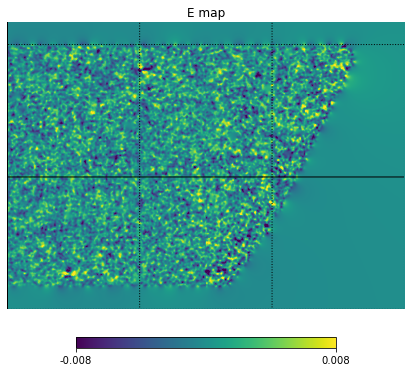

In [56]:
hp.cartview(E_map2, lonra=[90,180], latra=[-30,35], min=-0.008, max=0.008, title='E map')
hp.graticule()

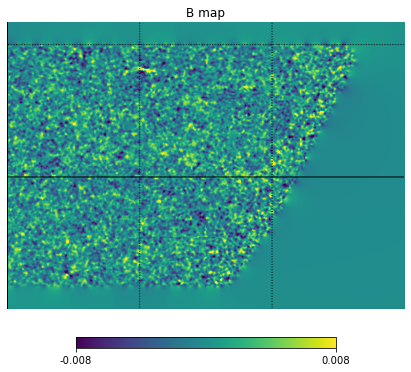

In [57]:
hp.cartview(B_map2, lonra=[90,180], latra=[-30,35], min=-0.008, max=0.008, title='B map')
hp.graticule()

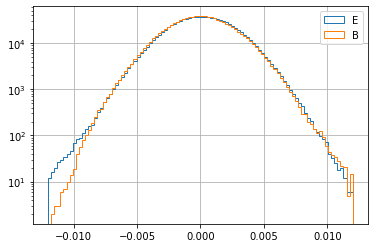

In [49]:
X1 = mplot.hist(E_map2[map_counts>0], range=(-0.012, 0.012), bins=100, histtype='step', label='E')
X2 = mplot.hist(B_map2[map_counts>0], range=(-0.012, 0.012), bins=100, histtype='step', label='B')
mplot.legend()
mplot.grid()
mplot.yscale('log')

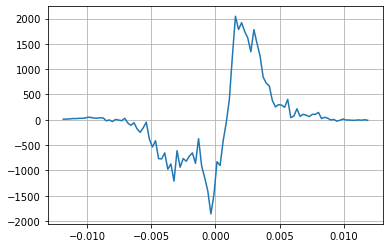

In [55]:
mplot.plot((X1[1][1:]+X1[1][:-1])/2, X1[0]-X2[0])
mplot.grid()